# Example Evaluation Visualization
This documents how to create comparative visualizations integrating
RNAseq, reference, Augustus, and Helixer predictions as seen in 
Fig 2. of the submited manuscript 
"Helixer: Cross-species Gene Annotation Of Large Eukaryotic Genomes Using Deep Learning"

## Data preparation
### reference data
You will need a reference genome and reference annotation (to follow this example 1:1).
We obtained ours from 
https://phytozome.jgi.doe.gov/pz/portal.html#!info?alias=Org_Mesculenta

and put both files in the folder 'reference/input'


### mapping file (indexed bam file)
You should start with _stranded_ (2nd strand sense / classic dUTP protocol) RNAseq data for you species of interest. You can process and map this with any method that creates a valid .bam file. We used FastQC for quality control, trimmomatic for trimming, and hisat2 for mapping, followed by samtools for indexing. If you're new to RNAseq analysis, we can recommend checking out a tool such as Galaxy (https://usegalaxy.org/) to get help with read processing and mapping. 

In this demo (Manihot esculenta) data, our mapping file is named
'Mesculenta.bam' and the index is 'Mesculenta.bam.bai' both in the directory mapping

### alternative data (Augustus gff3)
We will compare to _de novo_ predictions of Augustus, although this method could be used to compare to any gff3 file.

We put our augustus gff and a symlink to the reference genome in 'augustus/input'

### Helixer model
We'll go through all the steps of using a trained Helixer model, but the model itself we'll download.

```
wget https://zenodo.org/record/3974409/files/plants_a_e10.h5
```


### data structure
In summary, our files were as follows
```
.
├── augustus
│   └── input
│       ├── Mesculenta_305_v6.softmasked.fa
│       └── Mesculenta-augustus.gff3
├── mapping
│   ├── Mesculenta.bam
│   └── Mesculenta.bam.bai
├── plants_a_e10.h5
└── reference
    └── input
        ├── Mesculenta_305_v6.1.gene_exons.gff3
        └── Mesculenta_305_v6.softmasked.fa
```

## Helixer and GeenuFF repositories
For brevity we will store the path to the repositories
in a variable. You will likely need to adjust this to where
Helixer and GeenuFF are stored on your system

```
export helixer_path=/home/$USER/repos/github/weberlab-hhu/Helixer/
export geenuff_path=/home/$USER/repos/github/weberlab-hhu/GeenuFF/

```

## Data Processing

### reference -> GeenuFF -> test_data.h5

```
# import into GeenuFF db (reference/output/geenuff.sqlite3)
$geenuff_path/import2geenuff.py  --basedir reference --species Mesculenta
# export to h5 file (h5s/test_data.h5, this takes maybe 10 minutes)
$helixer_path/export.py --db-path-in reference/output/geenuff.sqlite3 --out-dir h5s --only-test-set --export-featureless
```
### add Augustus
```
# import into separate GeenuFF db (augustus/output/geenuff.sqlite3)
$geenuff_path/import2geenuff.py  --basedir augustus --species Mesculenta
# we will add the Augustus annotation to the existing h5 file created above (again, takes a bit)
$helixer_path/export.py --db-path-in augustus/output/geenuff.sqlite3 --out-dir h5s --only-test-set --export-featureless --add-additional augustus
```

### add coverage / mapping data
```
# how long this takes depends on the size of the .bam file; with 13GB it took ~3h
python3 $helixer_path/helixer/evaluation/training_rnaseq.py -s Mesculenta -d h5s/test_data.h5 -b mapping/Mesculenta.bam
```

### prepared file
At this point you can use e.g. h5f5 tools' `h5ls` to check that all the expected groups are there
in the h5 file. 

Running `h5ls h5s/test_data.h5`should return:

```
alternative              Group
data                     Group
evaluation               Group
meta                     Group
scores                   Group
```

### finally, let's make some Helixer predictions

```
# this takes about 4h with --overlap set, 
# and only about 1h if you remove the --overlap parameter
# without overlapping quality will drop at the end of chunks, 
# but not so much it hurts for a first look
python $helixer_path/helixer/prediction/LSTMModel.py --load-model-path plants_a_e10.h5 --prediction-output-path=Mesculenta_with_plants_a_e10.h5 --test-data h5s/test_data.h5 --layer-normalization --overlap
```

## Exploring and visualizing
### a first look

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# find and open files
fpath = 'h5s/test_data.h5'
ppath = 'Mesculenta_with_plants_a_e10.h5'

In [3]:
f = h5py.File(fpath, mode='r')
p = h5py.File(ppath, mode='r')

b'Mesculenta'
b'Chromosome01'
[420000 440000]


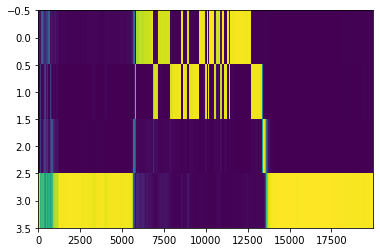

In [4]:
# let's look at an example from the manuscript where Helixer agrees with the reference and with the RNAseq
i = 21
# we can check the genomic region that this corresponds to
print(f['data/species'][i])
print(f['data/seqids'][i])
print(f['data/start_ends'][i])

# and we can make a quick heatmap of the predictions
plt.imshow(p['predictions'][i].T[::-1],  # [::-1] for more intuitive vertical flip
           aspect='auto', 
           interpolation='none')

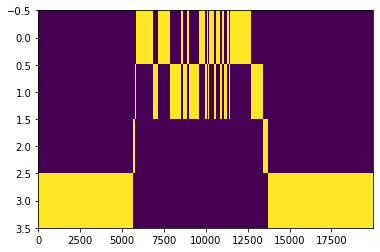

In [5]:
# similarly, we can make heatmaps of the reference at the same position
plt.imshow(f['data/y'][i].T[::-1],  # [::-1] for more intuitive vertical flip
           aspect='auto', 
           interpolation='none')

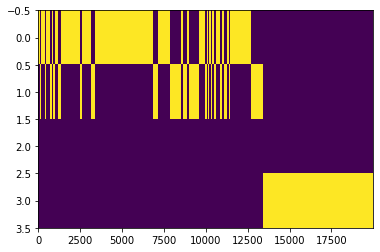

In [6]:
# and the augustus predictions
plt.imshow(f['alternative/augustus/y'][i].T[::-1],  # [::-1] for more intuitive vertical flip
           aspect='auto', 
           interpolation='none')

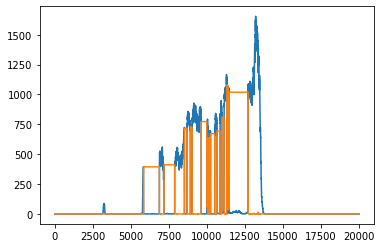

In [7]:
# finally, we can look at the coverage data
plt.plot(f['evaluation/coverage'][i])  # first will be blue
plt.plot(f['evaluation/spliced_coverage'][i])  # second will be orange


### making it pretty
(the plots, not the code)

now that we've gone through accessing and plotting things individually,
let's fast forward to more a more compact and aestheticly pleasing visualization.
The following function was used for fig 2. and similar figures in the manuscript

In [8]:
def plot_selected(i, f, p, start, end, figsize=(7, 4.2), as_int=True, legend=False, c_augline='gainsboro'):
    print(i)
    print(f['data/seqids'][i], f['data/start_ends'][i])
    fig, (ax1, ax2, axaug, ax3) = plt.subplots(4, 1, sharex=True, figsize=figsize,
                                             gridspec_kw={"height_ratios": [1.2, 0.5, 0.5, 0.5]})
    #plt.figure(figsize=(3,10))

    ax1.plot(np.log(f['evaluation/coverage'][i][start:end] + 1), c='black')
    ax1.plot(np.log(f['evaluation/spliced_coverage'][i][start:end] + 1), c='dimgrey', linestyle=':')
    ax1.set_xlim((0, end - start))
    ax1.set_ylabel("ln(coverage + 1)")
    if legend:
        ax1.legend(['cov', 'sc'])

    yticks = ['IG', 'UTR', 'CDS', 'Ntrn']
    ax2.imshow(1 - np.array(f['data/y'][i][start:end].T).astype(float), aspect="auto", 
               cmap='gray', interpolation='none')
    ax2.set_ylim([-0.5, 3.5])
    ax2.set_yticks([0,1,2, 3])
    ax2.set_yticklabels(yticks)
    ax2.set_ylabel('Ref.')

    axaug.imshow(1 - np.array(f['alternative/augustus/y'][i][start:end].T).astype(float), aspect="auto", 
                 cmap='gray', interpolation='none')
    utrmarker = np.array([1] * 20000)
    axaug.plot(utrmarker, linestyle=(0, (10, 5)), c=c_augline)
    axaug.set_ylim([-0.5, 3.5])
    axaug.set_yticks([0,1,2, 3])
    axaug.set_yticklabels(yticks)
    axaug.set_ylabel('Aug.')

    ax3.imshow(1 - np.array(p['predictions'][i][start:end].T).astype(float), aspect="auto", 
               cmap='gray', interpolation='none')
    ax3.set_ylim([-0.5, 3.5])
    ax3.set_yticks([0,1,2, 3])
    ax3.set_yticklabels(yticks)
    ax3.set_ylabel('Helixer')
    se = f['data/start_ends'][i]

    at = [x * (end - start) for x in [0, .2, .4, .60, .8, 1]]
    ax3.set_xticks(at)
    offset = f['data/start_ends'][i][0] + start
    if se[1] - se[0] > 0:
        sign = '+'
        xticklabs = [(offset + x)/ 10**3 for x in at]
    else:
        sign = '-'
        xticklabs = [(offset - x)/ 10**3 for x in at]
    if as_int:
        xticklabs = [int(x) for x in xticklabs]
    else:
        xticklabs = [round(x, 2) for x in xticklabs]
    ax3.set_xticklabels(xticklabs)
    ax3.set_xlabel('position on ({}) strand of {} in kbp'.format(sign, f['data/seqids'][i].decode()))
    

21
b'Chromosome01' [420000 440000]


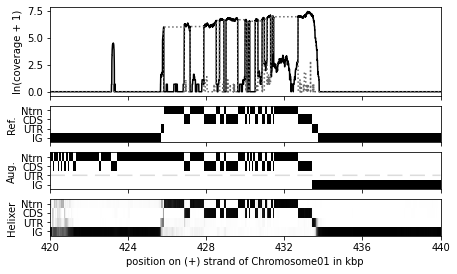

In [9]:
# plot all of chunk 21
i = 21
plot_selected(f=f, p=p, start=0, end=20000, i=i)

21
b'Chromosome01' [420000 440000]


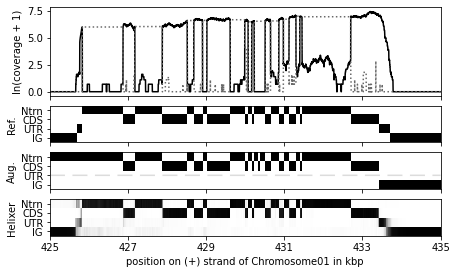

In [10]:
# or zoomed in for an exact match to Fig 2a
plot_selected(f=f, p=p, start=5000, end=15000, i=i)

In [11]:
# obviously, you can choose i as it suits you
# you can look at a gene of interest, say Manes.01G124200, 
# a phytoene synthase (PSY) mentioned here: https://doi.org/10.3389/fpls.2019.01570
# from the gff file we know this should be located at
# Chromosome01 24153420-24156720 on the + strand
# you can, for example use the function below to get the corresponding h5 index

In [12]:
def get_index_by_seqid_and_pos(f, seqid, position, is_plus_strand=True, chunk_size=20000):
    if not isinstance(seqid, bytes):
        seqid = seqid.encode('utf8')
    
    # round start down to be divisible by chunk_size
    expected_start = position - (position % chunk_size)
    # calculate end from start and strand
    if is_plus_strand:
        expected_end = expected_start + chunk_size
    else:
        expected_end = expected_start - chunk_size
    
    # recursive masking
    chr_mask = np.where(f['data/seqids'][:] == seqid)

    start_mask = np.where(f['data/start_ends'][chr_mask][:, 0] == expected_start)
    end_mask = np.where(f['data/start_ends'][chr_mask][start_mask][:, 1] == expected_end)
    # and finally back to the index
    i = np.arange(f['data/y'].shape[0])[chr_mask][start_mask][end_mask][0]
    return i

In [13]:
i = get_index_by_seqid_and_pos(f, 'Chromosome01', 24153420)
print(i)

1207


1207
b'Chromosome01' [24140000 24160000]


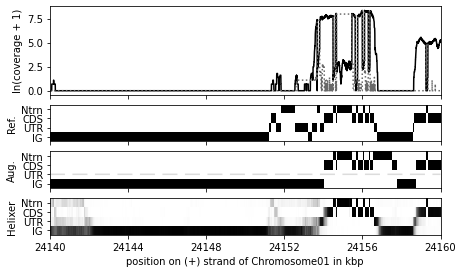

In [14]:
# whole chunk
plot_selected(f=f, p=p, start=0, end=20000, i=i)

1207
b'Chromosome01' [24140000 24160000]


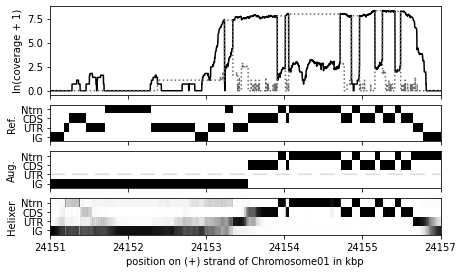

In [15]:
# or zooming in, we can see that Manes.01G124200 is predicted decently 
# with the exception of the first intron
# while the gene upstream of it is not, although the RNAseq doesn't exactly
# support the reference either. 
plot_selected(f=f, p=p, start=11000, end=17000, i=i)

In [16]:
# of course you can also 
# 
# choose i randomly to get a feel for things, or
#
# loop through different i values to see many things, or 
#
# calculate the % accuracy using f['data/y'] and 
# p['predictions'] and then search for chunks with 
# high or low accuracy, or
#
# use the dataset scores/one to search for regions where the
# reference has particularly good or bad coverage, or 
#
# whatever else suits your use case. 
# This is just a demo after all.

In [17]:
# particularly working interactively, it's good to close 
# the files once you're done
f.close()
p.close()